In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook demonstrates how to use EOTDL library to download Sentinel 2 images and automatically label them with AIS data.

Example developed from Agenium use case: https://github.com/earthpulse/eotdl/tree/main/tutorials/usecases/useCaseD

## Data access

In [46]:
ais_csv = {
    # date: ais_csv_path
    "2022-08-12": "../usecases/useCaseD/data/ais/crop_S2A_MSIL1C_20220812T103031_N0400_R108_T32UNF_20220812T155113.SAFE.csv",
    # "2022-08-25": "../usecases/useCaseD/data/ais/crop_S2A_MSIL1C_20220825T103641_N0400_R008_T32VPH_20220825T173926.SAFE.csv",
}

sensor = 'sentinel-2-l2a'

In [69]:
import pandas as pd
from functools import partial
from pathlib import Path
from eotdl.access import download_sentinel_imagery
from eotdl.tools import bbox_from_centroid

def rename_image(image_name, output_dir, date):
    image_path = Path(output_dir) / f"{image_name}.tiff"
    # bug in the naming convention in some cases where the date is added to the image name, cf issue #241
    downloaded_image_path = Path(output_dir) / f"{image_name}_{date}.tiff"
    if downloaded_image_path.exists():
        # Rename image
        downloaded_image_path.rename(image_path)
        # Rename json
        downloaded_json_path = Path(output_dir) / f"{image_name}_{date}.json"
        json_path = Path(output_dir) / f"{image_name}.json"
        downloaded_json_path.rename(json_path)
    return image_path

def download_boat_tile(row, date, output_dir, sensor="sentinel-2-l2a", image_size=128):
    if row["Type of mobile"] in ["Class A", "Class B"] and row["Length"] >= 15 and not row.isnull().values.any():
        # Get the bouding box
        y = row["Longitude"]
        x = row["Latitude"]
        bbox = bbox_from_centroid(x=x, y=y, pixel_size=10, width=image_size, height=image_size) 
        image_name = f"ship_{int(row['MMSI'])}_{date}"
        # Download the image
        download_sentinel_imagery(
            output=output_dir,
            time_interval=date,
            bounding_box=bbox,
            collection_id=sensor,
            name=image_name
        )        
        image_path = rename_image(image_name, output_dir, date)
        # Check that the image is downloaded
        if not image_path.exists():
            image_name = None
        return image_name

In [70]:
for date, ais_csv_path in ais_csv.items():
    print(f"Downloading images for {Path(ais_csv_path).name} :")
    ais_df = pd.read_csv(ais_csv_path)[:10] # only applying to first 10 rows for testing
    output_dir = Path("data/ais") 
    # Download boat images found in the csv
    download_function = partial(download_boat_tile, date=date, output_dir=output_dir)
    ais_df["ImageId"] = ais_df.apply(download_function, axis=1) 
    # Remove lines for which no image is found
    ais_df = ais_df.dropna(axis=0, subset=["ImageId"])
    # Save csv with the upadated image paths
    ais_df.to_csv(output_dir / Path(ais_csv_path).name, index=False)

In [71]:
from glob import glob

images = glob(str(output_dir) + "/*.tiff")
images

['data/ais/ship_210359000_2022-08-12.tiff',
 'data/ais/ship_210332000_2022-08-12.tiff',
 'data/ais/ship_210167000_2022-08-12.tiff',
 'data/ais/ship_210017000_2022-08-12.tiff',
 'data/ais/ship_209075000_2022-08-12.tiff']

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


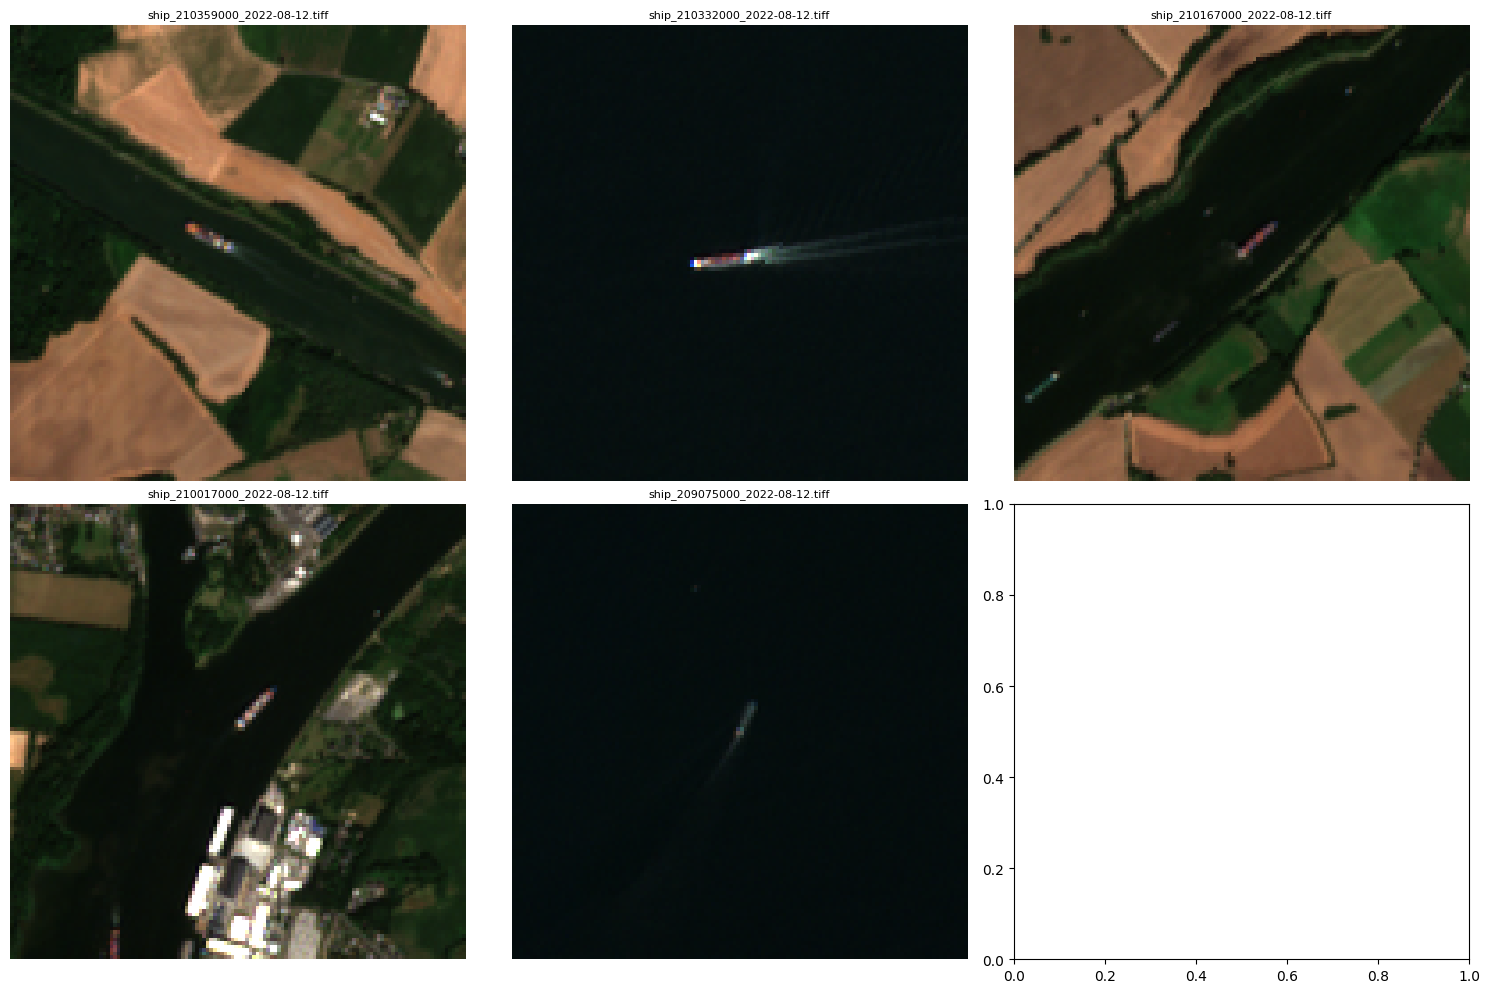

In [72]:
import rasterio as rio 
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, image_path in enumerate(images):
    ds = rio.open(image_path)
    rgb = np.clip(ds.read((4,3,2)) / 3000, 0, 1)
    
    axes[i].imshow(rgb.transpose(1,2,0))
    axes[i].set_title(Path(image_path).name, fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Labeling

In [77]:
from eotdl.tools.ais_labelling import process_db

data_path = "data/ais"

process_db(images_path=data_path,
           output_dir=data_path,
           upsample_factor=1,
           output_type="raster"
)

Processing tiles from data/ais


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


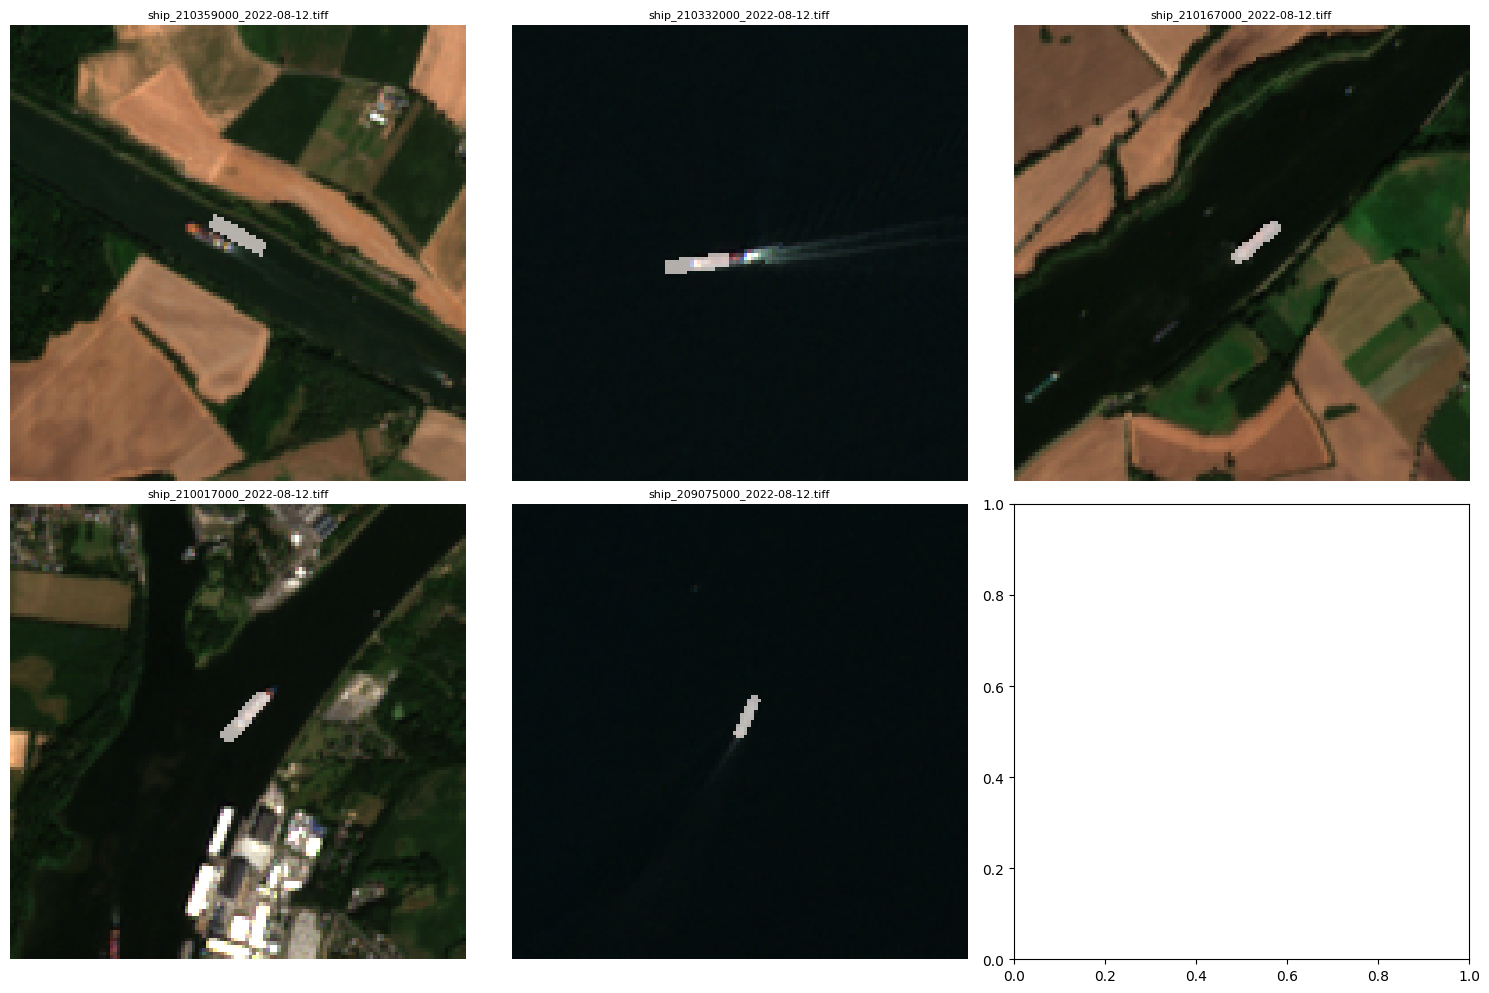

In [79]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, image_path in enumerate(images):
    ds = rio.open(image_path)
    rgb = np.clip(ds.read((4,3,2)) / 3000, 0, 1)
    
    # Display the image
    axes[i].imshow(rgb.transpose(1,2,0))
    axes[i].set_title(Path(image_path).name, fontsize=8)
    axes[i].axis('off')
    
    # Read and display the corresponding mask
    mask_path = str(Path(image_path).parent / f"mask_{Path(image_path).name}")
    if Path(mask_path).exists():
        mask_ds = rio.open(mask_path)
        mask = mask_ds.read(1)
        # Display mask as overlay
        axes[i].imshow(np.ma.masked_where(mask == 0, mask), 
                      alpha=0.7, cmap='Reds')

plt.tight_layout()
plt.show()